In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import warnings
import seaborn as sns
import ehrapy as ep
import anndata as ad

plt.style.use("ggplot")
warnings.filterwarnings("ignore")
from tableone import TableOne

In [91]:
df = pd.read_csv("notebooks/for_descriptives/icu_stay_diag_nocohort.csv.gz")


In [92]:
df['intime'] = pd.to_datetime(df['intime'], errors='coerce')
df['outtime'] = pd.to_datetime(df['outtime'], errors='coerce')
df['dod'] = pd.to_datetime(df['dod'], errors='coerce')

In [93]:
# Calculate days from admission to death
df['days_to_death'] = (df['dod'] - df['intime']).dt.days

# Calculate days from discharge to death, if death occurred after discharge
df['days_post_discharge_to_death'] = (df['dod'] - df['outtime']).dt.days

# Optional: clearly label deaths occurring after discharge
df['death_after_discharge'] = np.where(
    df['days_post_discharge_to_death'] > 0, True, False
)

# Handle cases with no death recorded (NaT in 'dod')
df.loc[df['dod'].isna(), ['days_to_death', 'days_post_discharge_to_death']] = np.nan

In [94]:
df_first_two = df.groupby('stay_id').head(1).reset_index(drop=True)

In [95]:
df_first_two.reset_index(drop=True, inplace=True)


In [96]:
adata = ep.io.df_to_anndata(df_first_two, 
            index_column='stay_id',
            columns_obs_only=['subject_id', 'icd_code', 'hadm_id', 'dod', 'intime', 'outtime'])

In [28]:
#icu_stay_df = pd.read_csv("data/cohort/cohort_icu_mortality_0_.csv.gz")
#icu_stay_merged.to_csv("notebooks/for_descriptives/icu_stay_diag_nocohort.csv.gz", index=False)
#adata = ep.io.read_csv("notebooks/for_descriptives/icu_stay_diag_nocohort.csv.gz", 
#            index_column='stay_id',
#            columns_obs_only=['subject_id', 'icd_code', 'hadm_id', 'dod', 'intime', 'outtime']) 

# 'dod', 'gender', 'ethnicity', 'insurance', 'disease_name', 'disease_type', 'hospital_death'

In [67]:
adata

AnnData object with n_obs × n_vars = 188634 × 11
    obs: 'subject_id', 'icd_code', 'hadm_id', 'dod', 'intime', 'outtime'
    layers: 'original'

In [97]:
ep.ad.infer_feature_types(adata)

! Feature 'hospital_death' was detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
 Detected feature types for AnnData 
object with 94444 obs and 11 vars
├── 📅 Date features
├── 📐 Numerical features
│   ├── Age
│   ├── days_post_discharge_to_death
│   ├── days_to_death
│   └── los
└── 🗂️ Categorical features
    ├── death_after_discharge (2 
    │   categories)
    ├── disease_name (904 categories)
    ├── disease_type (20 categories)
    ├── ethnicity (33 categories)
    ├── gender (2 categories)
    ├── hospital_death (2 categories)
    └── insurance (6 categories)


In [83]:
data = adata.to_df()
data.index = data.index.astype(int)

In [84]:
adata.var

,feature_type
Age,numeric
gender,categorical
ethnicity,categorical
insurance,categorical
hospital_death,categorical
los,numeric
disease_name,categorical
disease_type,categorical
days_to_death,numeric
days_post_discharge_to_death,numeric


In [85]:
obs_qc, var_qc = ep.pp.qc_metrics(adata)

In [98]:
ep.ad.feature_type_overview(adata)

 Detected feature types for AnnData 
object with 94444 obs and 11 vars
├── 📅 Date features
├── 📐 Numerical features
│   ├── Age
│   ├── days_post_discharge_to_death
│   ├── days_to_death
│   └── los
└── 🗂️ Categorical features
    ├── death_after_discharge (2 
    │   categories)
    ├── disease_name (904 categories)
    ├── disease_type (20 categories)
    ├── ethnicity (33 categories)
    ├── gender (2 categories)
    ├── hospital_death (2 categories)
    └── insurance (6 categories)


In [100]:
adata = ep.pp.encode(adata, encodings={"one-hot": ["gender", 'ethnicity', 'insurance', 'disease_name',  'disease_type','hospital_death', 'death_after_discharge']})

Finished one-hot encoding. ------ 100%


In [89]:
 adata.var

,feature_type,unencoded_var_names,encoding_mode
ehrapycat_gender_F,categorical,gender,one-hot
ehrapycat_gender_M,categorical,gender,one-hot
ehrapycat_ethnicity_AMERICAN INDIAN/ALASKA NATIVE,categorical,ethnicity,one-hot
ehrapycat_ethnicity_ASIAN,categorical,ethnicity,one-hot
ehrapycat_ethnicity_ASIAN - ASIAN INDIAN,categorical,ethnicity,one-hot
...,...,...,...
ehrapycat_death_after_discharge_True,categorical,death_after_discharge,one-hot
Age,numeric,Age,None
los,numeric,los,None
days_to_death,numeric,days_to_death,None


In [19]:
#ep.ad.replace_feature_types(adata, ["hospital_death"], "categorical")

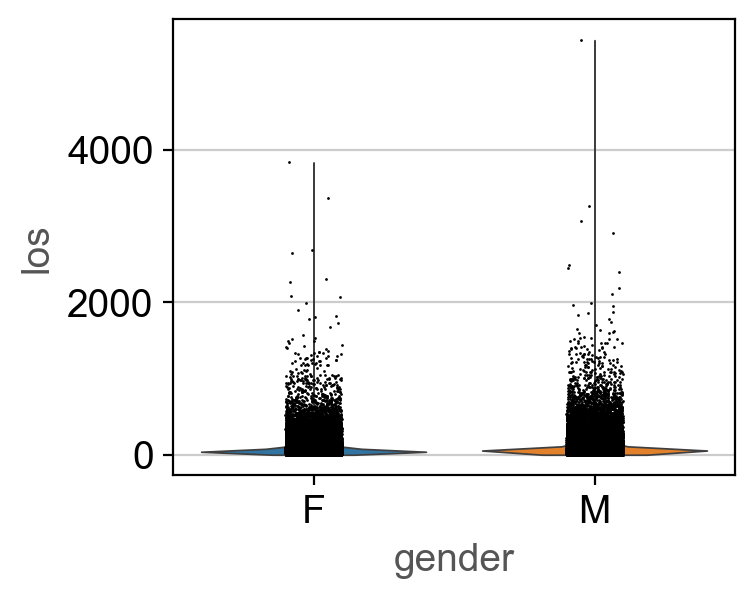

In [102]:
#ep.settings.set_figure_params(figsize=(4, 3), dpi=100)
ep.pl.violin(adata, keys=["los"], groupby="gender")

In [103]:
obs_metric, var_metrics = ep.pp.qc_metrics(adata)

In [ ]:
ep.pp.qc_metrics(adata)

In [ ]:
ep.pp.knn_impute(adata, n_neighbours=5)

In [ ]:
ep.pp.qc_metrics(adata)